In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from facenet_pytorch import MTCNN
from tqdm import tqdm  # Import tqdm for progress bars



# Define the dataset class for loading images
class ArtworksDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert('RGB')  # Ensure RGB format
        if self.transform:
            img = self.transform(img)
        return img

# Function to load images from directory
def load_image_paths_from_directory(root_dir):
    image_paths = []
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith(('jpg', 'jpeg', 'png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

# Initialize MTCNN for face detection
mtcnn = MTCNN(keep_all=True)

# Function to detect faces using MTCNN
def detect_faces(image):
    faces, _ = mtcnn.detect(image)
    return faces is not None and len(faces) > 0

# Apply PCA for dimensionality reduction
def apply_pca(features, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_features = pca.fit_transform(features)
    return reduced_features

# Function to perform clustering (KMeans) on the dataset features
def perform_kmeans_clustering(features, n_clusters=2):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(features)
    return kmeans_labels, kmeans.cluster_centers_

# Function to visualize the PCA results and KMeans clustering
def visualize_clusters_pca(features, kmeans_labels):
    reduced_features = apply_pca(features, n_components=2)
    plt.figure(figsize=(8, 6))
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.6)
    plt.title('PCA of Artworks')
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

# Main function to load data, extract features, apply clustering and visualization
def analyze_artworks(real_artworks_dir, fake_artworks_dir, batch_size=32):
    # Load the image paths for real and fake datasets
    real_image_paths = load_image_paths_from_directory(real_artworks_dir)
    fake_image_paths = load_image_paths_from_directory(fake_artworks_dir)

    
    # Define image transformations (resizing, normalization)
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])

    # Create datasets and dataloaders
    real_dataset = ArtworksDataset(real_image_paths, transform=transform)
    fake_dataset = ArtworksDataset(fake_image_paths, transform=transform)

    real_loader = DataLoader(real_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    fake_loader = DataLoader(fake_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   
    # Load pre-trained ResNet50 model for feature extraction
    model = models.resnet50(pretrained=True).to(device)
    model.eval()  # Set to evaluation mode

    def extract_features(loader):
        features = []
        labels = []
        with torch.no_grad():
            for data in tqdm(loader, desc="Extracting Features", leave=False):
                data = data.to(device)  # Move to GPU if available
                output = model(data)  # Get feature output from ResNet
                features.append(output.cpu().numpy())  # Move features back to CPU
                labels.extend([0] * len(data))  # Assign label '0' for real artworks
        return np.concatenate(features, axis=0), np.array(labels)

    # Extract features from real and fake artworks
    real_features, real_labels = extract_features(real_loader)
    fake_features, fake_labels = extract_features(fake_loader)


    # Concatenate real and fake features for clustering
    all_features = np.concatenate([real_features, fake_features], axis=0)

    # Perform KMeans clustering
    kmeans_labels, cluster_centers = perform_kmeans_clustering(all_features, n_clusters=2)

    # Visualize the clustering results using PCA
    visualize_clusters_pca(all_features, kmeans_labels)

    # Count and calculate the percentage of portrait artworks
    portrait_count = 0
    total_count = 0

    for img_path in tqdm(real_image_paths + fake_image_paths, desc="Detecting Portraits", leave=False):
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).cuda()  # Convert image to tensor and move to GPU
        if detect_faces(img_tensor):  # Detect faces in the image
            portrait_count += 1
        total_count += 1

    # Calculate percentage of portraits in total dataset
    portrait_percentage = (portrait_count / total_count) * 100
    print(f"Percentage of portrait artworks: {portrait_percentage:.2f}%")




['../data/artifact/generated/stylegan3-t-metfaces-1024x1024/img005041.jpg', '../data/artifact/generated/stylegan3-t-metfaces-1024x1024/img003864.jpg', '../data/artifact/generated/stylegan3-t-metfaces-1024x1024/img001332.jpg', '../data/artifact/generated/stylegan3-t-metfaces-1024x1024/img007136.jpg', '../data/artifact/generated/stylegan3-t-metfaces-1024x1024/img002801.jpg', '../data/artifact/generated/stylegan3-t-metfaces-1024x1024/img003053.jpg', '../data/artifact/generated/stylegan3-t-metfaces-1024x1024/img006681.jpg', '../data/artifact/generated/stylegan3-t-metfaces-1024x1024/img001014.jpg', '../data/artifact/generated/stylegan3-t-metfaces-1024x1024/img005097.jpg', '../data/artifact/generated/stylegan3-t-metfaces-1024x1024/img000956.jpg', '../data/artifact/generated/stylegan3-t-metfaces-1024x1024/img006032.jpg', '../data/artifact/generated/stylegan3-t-metfaces-1024x1024/img003413.jpg', '../data/artifact/generated/stylegan3-t-metfaces-1024x1024/img005100.jpg', '../data/artifact/genera

/home/oem/miniconda3/envs/python3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/oem/miniconda3/envs/python3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


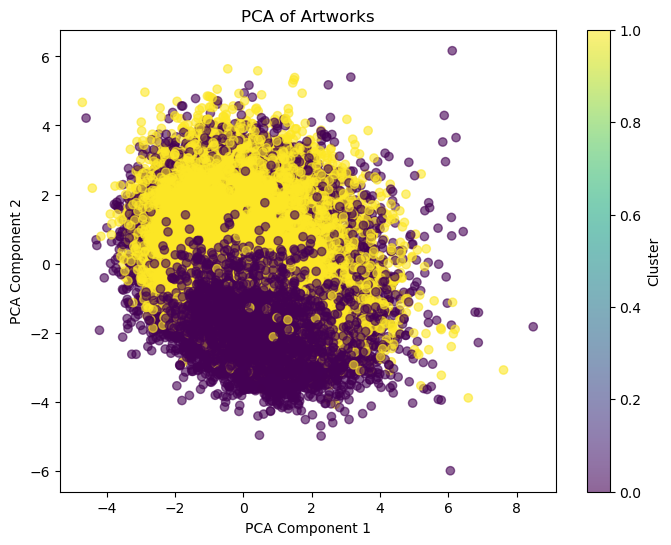

RuntimeError: torch.cat(): expected a non-empty list of Tensors

In [5]:

base_data_dir = '../data/artifact'
generated_artworks_dir = os.path.join(base_data_dir, 'generated') 
real_artworks_dir = os.path.join(base_data_dir, 'real')
analyze_artworks(real_artworks_dir, generated_artworks_dir)